In [ ]:
#| default_exp fastprogress

In [ ]:
#| export
import time,shutil
from sys import stdout
from warnings import warn

from fastcore.utils import *
from fasthtml.common import *

from IPython.display import display,HTML,Markdown

## Display

In [ ]:
#| export
def format_time(t):
    "Format `t` (in seconds) to (h):mm:ss"
    t = int(t)
    h,m,s = t//3600, (t//60)%60, t%60
    if h!= 0: return f'{h}:{m:02d}:{s:02d}'
    else:     return f'{m:02d}:{s:02d}'

In [ ]:
assert format_time(12) == '00:12'
assert format_time(512) == '08:32'
assert format_time(3712) == '1:01:52'

In [ ]:
#| export
html_styles = """
<style>
    progress { appearance: none; border: none; border-radius: 4px; width: 300px;
        height: 20px; vertical-align: middle; background: #e0e0e0; }

    progress::-webkit-progress-bar { background: #e0e0e0; border-radius: 4px; }
    progress::-webkit-progress-value { background: #2196F3; border-radius: 4px; }
    progress::-moz-progress-bar { background: #2196F3; border-radius: 4px; }

    progress:not([value]) {
        background: repeating-linear-gradient(45deg, #7e7e7e, #7e7e7e 10px, #5c5c5c 10px, #5c5c5c 20px); }

    progress.progress-bar-interrupted::-webkit-progress-value { background: #F44336; }
    progress.progress-bar-interrupted::-moz-progress-value { background: #F44336; }
    progress.progress-bar-interrupted::-webkit-progress-bar { background: #F44336; }
    progress.progress-bar-interrupted::-moz-progress-bar { background: #F44336; }
    progress.progress-bar-interrupted { background: #F44336; }    

    table.fastprogress { border-collapse: collapse; margin: 1em 0; font-size: 0.9em; }
    table.fastprogress th, table.fastprogress td { padding: 8px 12px; border: 1px solid #ddd; text-align: left; }
    table.fastprogress thead tr { background: #f8f9fa; font-weight: bold; }
    table.fastprogress tbody tr:nth-of-type(even) { background: #f8f9fa; }
</style>
"""

In [ ]:
#| export
_style_shown = False
def show_styles():
    "Add the styles to the nb/dialog"
    global _style_shown
    if _style_shown: return
    display(HTML(html_styles))
    _style_shown=True

In [ ]:
show_styles()

In [ ]:
#| export
def html_progress_bar(value, total, label, interrupted=False):
    "Html code for a progress bar `value`/`total` with `label`"
    cls = 'progress-bar-interrupted' if interrupted else None
    attrs = dict(max=total, cls=cls)
    if total is not None: attrs['value'] = value
    return Div(Progress(**attrs), ' ', label)

In [ ]:
html_progress_bar(45, 100, '45/100 [00:23<00:28]')

<div><progress max="100" value="45"></progress> 45/100 [00:23&lt;00:28]</div>

In [ ]:
#| export
def text2html_table(items):
    "Put the texts in `items` in an HTML table."
    hdr = Tr(map(Th, items[0]))
    rows = [Tr(map(Td, line)) for line in items[1:]]
    return Table(Thead(hdr), Tbody(*rows), cls='fastprogress')

In [ ]:
test_data = [['epoch', 'train_loss', 'valid_loss', 'time'], 
             ['0', '0.365241', '0.186934', '00:12'],
             ['1', '0.165239', '0.142865', '00:11'],
             ['2', '0.125647', '0.138421', '00:11']]

In [ ]:
text2html_table(test_data)

epoch,train_loss,valid_loss,time
0,0.365241,0.186934,00:12
1,0.165239,0.142865,00:11
2,0.125647,0.138421,00:11


## Base class

In [ ]:
#| export
class ProgressBar:
    update_every,first_its,lt = 0.2,5,'<'
    def __init__(self, gen, total=None, display=True, leave=True, parent=None, master=None, comment=''):
        store_attr()
        self.total = None if total=='noinfer' else len(gen) if total is None else total
        if parent is None: self.leave,self.display = leave,display
        else:
            self.leave,self.display = False,False
            parent.add_child(self)
        self.last_v = None

    def on_update(self, val, text): pass

    def update_bar(self, val):
        if self.total == 0:
            warn("Your generator is empty.")
            return self.on_update(0, '100% [0/0]')
        pct = '' if self.total is None else f'{100 * val/self.total:.2f}% '
        tot = '?' if self.total is None else str(self.total)
        elapsed_t = self.last_t - self.start_t
        remaining_t = '?' if self.pred_t is None else format_time(self.pred_t - elapsed_t)
        elapsed_t = format_time(elapsed_t)
        end = f'... {self.comment}' if self.comment else ''
        self.on_update(val, f'{pct}[{val}/{tot} {elapsed_t}{self.lt}{remaining_t}{end}]')

In [ ]:
class PrintProgressBar(ProgressBar):
    def on_update(self, val, text): print(text)

In [ ]:
pb = PrintProgressBar(range(10))
pb.start_t = pb.last_t = time.time()
pb.pred_t = 5.0
pb.update_bar(3)

30.00% [3/10 00:00<00:05]


In [ ]:
pb.update_bar(4)

40.00% [4/10 00:00<00:05]


In [ ]:
#| export
@patch
def update(self:ProgressBar, val):
    if self.last_v is None: 
        self.on_iter_begin()
        self.last_v = 0
    if val == 0:
        self.start_t = self.last_t = time.time()
        self.pred_t,self.last_v,self.wait_for = None,0,1
        self.update_bar(0)
    elif val<=self.first_its or val>=self.last_v+self.wait_for or (self.total and val>=self.total):
        cur_t = time.time()
        avg_t = (cur_t-self.start_t) / val
        self.wait_for = max(int(self.update_every/(avg_t+1e-8)),1)
        self.pred_t = None if self.total is None else avg_t * self.total
        self.last_v,self.last_t = val,cur_t
        self.update_bar(val)
        if self.total is not None and val >= self.total:
            self.on_iter_end()
            self.last_v = None

@patch
def on_iter_begin(self:ProgressBar):
    if self.master is not None: self.master.on_iter_begin()

@patch
def on_interrupt(self:ProgressBar):
    if self.master is not None: self.master.on_interrupt()

@patch
def on_iter_end(self:ProgressBar):
    if self.master is not None: self.master.on_iter_end()

In [ ]:
pb = PrintProgressBar(range(5))
for i in range(6): pb.update(i); time.sleep(0.02)

0.00% [0/5 00:00<?]
20.00% [1/5 00:00<00:00]
40.00% [2/5 00:00<00:00]
60.00% [3/5 00:00<00:00]
80.00% [4/5 00:00<00:00]
100.00% [5/5 00:00<00:00]


In [ ]:
#| export
@patch
def __iter__(self:ProgressBar):
    if self.total != 0: self.update(0)
    try:
        for i,o in enumerate(self.gen):
            if self.total and i >= self.total: break
            yield o
            self.update(i+1)
        if self.total is None and self.last_v is not None:
            self.total = i+1
            self.update(self.total)
    except Exception as e:
        self.on_interrupt()
        raise e

In [ ]:
for i in PrintProgressBar(range(5)): time.sleep(0.02)

0.00% [0/5 00:00<?]
20.00% [1/5 00:00<00:00]
40.00% [2/5 00:00<00:00]
60.00% [3/5 00:00<00:00]
80.00% [4/5 00:00<00:00]
100.00% [5/5 00:00<00:00]


In [ ]:
#| export
class MasterBar(ProgressBar):
    def __init__(self, gen, cls, total=None): self.main_bar = cls(gen, total=total, display=False, master=self)
    def on_iter_begin(self): pass
    def on_interrupt(self):  pass
    def on_iter_end(self):   pass
    def add_child(self, child): pass
    def write(self, line):      pass
    def update_graph(self, graphs, x_bounds, y_bounds): pass
    def __iter__(self): yield from self.main_bar
    def update(self, val): self.main_bar.update(val)
    def progress(self, *args, **kwargs): return self.pcls(*args, parent=self, **kwargs)

## Notebook progress bars

In [ ]:
#| export
if IN_NOTEBOOK:
    try:
        from IPython.display import clear_output, display, HTML
        import matplotlib.pyplot as plt
    except:
        warn("Couldn't import ipython display functions, progress bar will use console behavior")
        IN_NOTEBOOK = False

In [ ]:
#| export
class NBProgressBar(ProgressBar):
    def on_iter_begin(self):
        super().on_iter_begin()
        self.progress = html_progress_bar(0, self.total, "")
        if self.display:
            show_styles()
            self.out = display(self.progress, display_id=True)
        self.is_active=True

    def on_interrupt(self):
        self.on_update(0, 'Interrupted', interrupted=True)
        super().on_interrupt()
        self.on_iter_end()

    def on_iter_end(self):
        if not self.leave and self.display: self.out.update(HTML(''))
        self.is_active=False
        super().on_iter_end()
        
    def on_update(self, val, text, interrupted=False):
        self.progress = html_progress_bar(val, self.total, text, interrupted)
        if self.display: self.out.update(self.progress)
        elif self.parent is not None: self.parent.show()
        elif hasattr(self, '_parent_show'): self._parent_show()

In [ ]:
tst = NBProgressBar(range(30))
for i in tst: time.sleep(0.02)

<div><progress max="30" value="30"></progress> 100.00% [30/30 00:00&lt;00:00]</div>

In [ ]:
tst = NBProgressBar(range(50))
for i in range(30): 
    time.sleep(0.02)
    tst.update(i)
tst.on_interrupt()

<div><progress max="50" value="0" class="progress-bar-interrupted"></progress> Interrupted</div>

In [ ]:
tst = NBProgressBar(range(30), total='noinfer')
for i in range(30):
    time.sleep(0.02)
    tst.update(i)

<div><progress></progress> [22/? 00:00&lt;?]</div>

In [ ]:
#| hide
for i in NBProgressBar([]): pass

In [ ]:
#| export
class NBMasterBar(MasterBar):
    pcls = NBProgressBar
    def __init__(self, gen, total=None, hide_graph=False, order=None, clean_on_interrupt=False, total_time=False,
            names=('train', 'valid'), hdrs=None):
        super().__init__(gen, NBProgressBar, total)
        if order is None: order = ['pb1', 'text', 'pb2']
        store_attr('hide_graph,order,clean_on_interrupt,total_time,names,hdrs')
        self.report,self.lines,self.text_parts = [],[],[]
        self.inner_dict = dict(pb1=self.main_bar)
        
    def on_iter_begin(self):
        show_styles()
        self.out = display(Div(html_progress_bar(0, self.main_bar.total, "")), display_id=True)
        self.main_bar._parent_show = self.show
        if self.hdrs is not None: self.write(self.hdrs, table=True)

    def on_interrupt(self):
        if self.clean_on_interrupt: self.out.update(HTML(''))

    def on_iter_end(self):
        if hasattr(self, 'imgs_fig'): plt.close(); self.imgs_out.update(self.imgs_fig)
        if hasattr(self, 'graph_fig'): plt.close(); self.graph_out.update(self.graph_fig)
        hdr = [P(f'Total time: {format_time(time.time() - self.main_bar.start_t)}')] if self.total_time else []
        if hasattr(self, 'out'): self.out.update(Div(*hdr, *self.text_parts))

    def add_child(self, child):
        self.child = child
        self.inner_dict['pb2'] = self.child

    def show(self):
        self.inner_dict['text'] = Div(*self.text_parts)
        children = [getattr(item, 'progress', None) or item for n in self.order
            if (item := self.inner_dict.get(n))]
        if hasattr(self, 'out'): self.out.update(Div(*children))

    def write(self, line, table=False):
        if table: self.lines.append(line); self.text_parts = [text2html_table(self.lines)]
        else: self.text_parts.append(P(line))
        self.show()

In [ ]:
for i in (mb := NBMasterBar(range(5), hdrs=['epoch', 'train_loss', 'valid_loss'])):
    mb.main_bar.comment = f'first bar stat'
    for j in mb.progress(range(10)):
        time.sleep(0.02)
        mb.child.comment = f'second bar stat'
    mb.write([str(i), f'{1/(i+1):.3f}', f'{1.2/(i+1):.3f}'], table=True)

epoch,train_loss,valid_loss
0,1.000,1.200
1,0.500,0.600
2,0.333,0.400
3,0.250,0.300
4,0.200,0.240


In [ ]:
#| export
@patch
def show_imgs(self:NBMasterBar, imgs, titles=None, cols=4, imgsize=4, figsize=None):
    if self.hide_graph: return
    rows = len(imgs)//cols if len(imgs)%cols == 0 else len(imgs)//cols + 1
    if figsize is None: figsize = (imgsize*cols, imgsize*rows)
    self.imgs_fig, imgs_axs = plt.subplots(rows, cols, figsize=figsize)
    if titles is None: titles = [None] * len(imgs)
    for img, ax, title in zip(imgs, imgs_axs.flatten(), titles): img.show(ax=ax, title=title)
    for ax in imgs_axs.flatten()[len(imgs):]: ax.axis('off')
    if not hasattr(self, 'imgs_out'): self.imgs_out = display(self.imgs_fig, display_id=True)
    else: self.imgs_out.update(self.imgs_fig)
    plt.close(self.imgs_fig)

In [ ]:
import numpy as np

In [ ]:
class Img:
    def __init__(self, data): self.data = data
    def show(self, ax, title=None):
        ax.imshow(self.data)
        if title: ax.set_title(title)

<div></div>

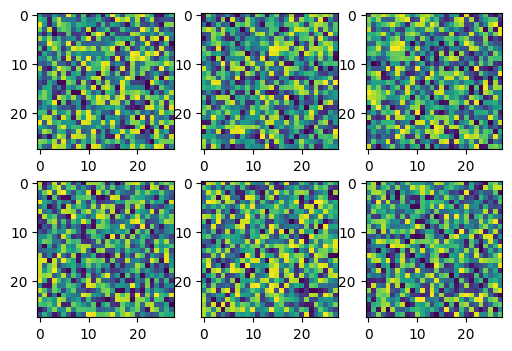

In [ ]:
for i in (mb := NBMasterBar(range(5))):
    imgs = [Img(np.random.rand(28,28)) for _ in range(6)]
    mb.show_imgs(imgs, cols=3, imgsize=2)
    time.sleep(0.2)

In [ ]:
#| export
@patch
def update_graph(self:NBMasterBar, graphs, x_bounds=None, y_bounds=None, figsize=(6,4)):
    if self.hide_graph: return
    if not hasattr(self, 'graph_fig'):
        self.graph_fig, self.graph_ax = plt.subplots(1, figsize=figsize)
        self.graph_out = display(self.graph_ax.figure, display_id=True)
    self.graph_ax.clear()
    if len(self.names) < len(graphs): self.names += [''] * (len(graphs) - len(self.names))
    for g,n in zip(graphs,self.names): self.graph_ax.plot(*g, label=n)
    self.graph_ax.legend(loc='upper right')
    if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)
    if y_bounds is not None: self.graph_ax.set_ylim(*y_bounds)
    self.graph_out.update(self.graph_ax.figure)

epoch,train_loss,valid_loss
0,1.093,1.243
1,0.587,0.689
2,0.384,0.450
3,0.257,0.392
4,0.230,0.268
5,0.194,0.241
6,0.241,0.243
7,0.141,0.193
8,0.145,0.199
9,0.103,0.188


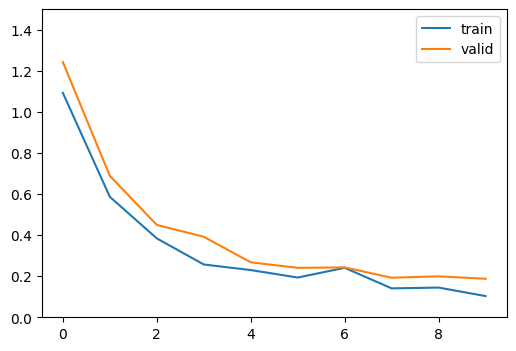

In [ ]:
train_losses, valid_losses = [], []
for i in (mb:=NBMasterBar(range(10))):
    mb.write(['epoch', 'train_loss', 'valid_loss'], table=True) if i==0 else None
    tl = 1.0/(i+1) + np.random.rand()*0.1
    vl = 1.2/(i+1) + np.random.rand()*0.1
    train_losses.append((i, tl))
    valid_losses.append((i, vl))
    graphs = [list(zip(*train_losses)), list(zip(*valid_losses))]
    mb.update_graph(graphs, y_bounds=(0,1.5))
    mb.write([str(i), f'{tl:.3f}', f'{vl:.3f}'], table=True)
    time.sleep(0.3)

## Console progress bars

In [ ]:
#| export
NO_BAR = False
WRITER_FN = print
FLUSH = True
SAVE_PATH = None
SAVE_APPEND = False
MAX_COLS = 160

In [ ]:
#| export
def printing():
    "`True` if we want to print progress"
    if NO_BAR: return False
    return getattr(stdout, 'isatty', False) or IN_NOTEBOOK or 'PYCHARM_HOSTED' in os.environ

In [ ]:
#| export
class ConsoleProgressBar(ProgressBar):
    fill:str='█'
    end:str=''

    def __init__(self, gen, total=None, display=True, leave=True, parent=None, master=None, txt_len=60):
        self.cols,_ = shutil.get_terminal_size((100, 40))
        if self.cols > MAX_COLS: self.cols=MAX_COLS
        self.length = self.cols-txt_len
        self.max_len,self.prefix = 0,''
        #In case the filling char returns an encoding error
        try: print(self.fill, end='\r', flush=FLUSH)
        except: self.fill = 'X'
        super().__init__(gen, total, display, leave, parent, master)

    def on_interrupt(self):
        super().on_interrupt()
        self.on_iter_end()

    def on_iter_end(self):
        if not self.leave and printing():
            print(f'\r{self.prefix}' + ' ' * (self.max_len - len(f'\r{self.prefix}')), end='\r', flush=FLUSH)
        super().on_iter_end()

    def on_update(self, val, text):
        if self.display:
            if self.length > self.cols-len(text)-len(self.prefix)-4:
                self.length = self.cols-len(text)-len(self.prefix)-4
            filled_len = int(self.length * val // self.total) if self.total else 0
            bar = self.fill * filled_len + '-' * (self.length - filled_len)
            to_write = f'\r{self.prefix} |{bar}| {text}'
            # if self.total and val >= self.total: end = '\r'
            # else: end = self.end
            if len(to_write) > self.max_len: self.max_len=len(to_write)
            if printing(): WRITER_FN(to_write, end='', flush=FLUSH)

In [ ]:
tst = ConsoleProgressBar(range(50))
for i in tst: time.sleep(0.02)

 |████████████████████████████████████████| 100.00% [50/50 00:01<00:00]

In [ ]:
tst = ConsoleProgressBar(range(100))
for i in range(50): 
    time.sleep(0.02)
    tst.update(i)
tst.on_interrupt()

 |████████████████------------------------| 41.00% [41/100 00:00<00:01]

In [ ]:
tst = ConsoleProgressBar(range(100), total='noinfer')
for i in range(50):
    time.sleep(0.02)
    tst.update(i)

 |----------------------------------------| [41/? 00:00<?]

In [ ]:
#| export
def print_and_maybe_save(line):
    WRITER_FN(line)
    if SAVE_PATH is not None:
        attr = "a" if os.path.exists(SAVE_PATH) else "w"
        with open(SAVE_PATH, attr) as f: f.write(line + '\n')

In [ ]:
#| export
class ConsoleMasterBar(MasterBar):
    pcls = ConsoleProgressBar
    def __init__(self, gen, total=None, hide_graph=False, order=None, clean_on_interrupt=False, total_time=False):
        super().__init__(gen, ConsoleProgressBar, total)
        self.total_time = total_time

    def add_child(self, child):
        self.child = child
        v = 0 if self.main_bar.last_v is None else self.main_bar.last_v
        self.child.prefix = f'Epoch {v+1}/{self.main_bar.total} :'
        self.child.display = True

    def on_iter_begin(self):
        super().on_iter_begin()
        if SAVE_PATH is not None and os.path.exists(SAVE_PATH) and not SAVE_APPEND:
            with open(SAVE_PATH, 'w') as f: f.write('')

    def write(self, line, table=False):
        if table:
            text = ''
            if not hasattr(self, 'names'):
                self.names = [name + ' ' * (8-len(name)) if len(name) < 8 else name for name in line]
                text = '  '.join(self.names)
            else:
                for (t,name) in zip(line,self.names): text += t + ' ' * (2 + len(name)-len(t))
            print_and_maybe_save(text)
        else: print_and_maybe_save(line)
        if self.total_time:
            total_time = format_time(time() - self.start_t)
            print_and_maybe_save(f'Total time: {total_time}')

    def show_imgs(*args, **kwargs): pass
    def update_graph(*args, **kwargs): pass

In [ ]:
for i in (mb := ConsoleMasterBar(range(5))):
    for j in mb.progress(range(10)):
        time.sleep(0.02)
        mb.child.comment = f'second bar stat'
    mb.main_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')

Finished loop 0.                                                                                    
Finished loop 1.                                                                                    
Finished loop 2.                                                                                    
Finished loop 3.                                                                                    
Finished loop 4.                                                                                    


In [ ]:
mb = ConsoleMasterBar(range(5))
mb.update(0)  
for i in range(5):
    for j in ConsoleProgressBar(range(10), parent=mb):
        time.sleep(0.02)
        mb.child.comment = f'second bar stat'
    mb.main_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')
    mb.update(i+1)

Finished loop 0.                                                                                    
Finished loop 1.                                                                                    
Finished loop 2.                                                                                    
Finished loop 3.                                                                                    
Finished loop 4.                                                                                    


In [ ]:
#| export
if IN_NOTEBOOK: master_bar, progress_bar = NBMasterBar, NBProgressBar
else:           master_bar, progress_bar = ConsoleMasterBar, ConsoleProgressBar

In [ ]:
#| export
def force_console_behavior():
    "Return the console progress bars"
    return ConsoleMasterBar, ConsoleProgressBar

In [ ]:
#| export
_all_ = ['master_bar', 'progress_bar']

## Export -

In [ ]:
from nbdev import nbdev_export
nbdev_export()